In [2]:
import pandas as pd
import numpy as np

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Exploring User 010's labeled trips 
Using `traj_parse.py` on the GPS dataset, I extracted a single user's GPS coordinates, labeled with the transit mode, into a csv: `010_trip_labeled.csv`. The purpose of this notebook is to do some initial exploring of the dataset

### Read in data using Pandas
Add a timestamp column and remove any coordinates without a trip ID label

In [4]:
data_cols = ['latitude', 'longitude',
             'height', 'days_float',
             'rec_date', 'rec_time',
             'timestamp', 'user_id',
             'trip_id', 'transit']
tpoints = (pd.read_csv('010_trip_labeled.csv',
                       index_col=0,
                       names=data_cols,
                       header=0)
             .drop('days_float' ,axis=1)
             .assign(timestamp = lambda x: pd.to_datetime(x.timestamp))
             .sort_values(['trip_id','timestamp'])
          )
tpoints = tpoints.loc[(~tpoints.trip_id.isnull())].copy()

### Check out data

In [5]:
tpoints.head(10)

,latitude,longitude,height,rec_date,rec_time,timestamp,user_id,trip_id,transit
1,39.894178,116.318200,-777,2008-03-28,14:54:40,2008-03-28 14:54:40,10,1.0,train
2,39.894505,116.321132,-777,2008-03-28,14:55:14,2008-03-28 14:55:14,10,1.0,train
3,39.894953,116.326452,-777,2008-03-28,14:56:13,2008-03-28 14:56:13,10,1.0,train
4,39.894600,116.332542,-777,2008-03-28,14:57:12,2008-03-28 14:57:12,10,1.0,train
5,39.889622,116.337040,-777,2008-03-28,14:58:11,2008-03-28 14:58:11,10,1.0,train
6,39.882090,116.338353,-777,2008-03-28,14:59:10,2008-03-28 14:59:10,10,1.0,train
7,39.873873,116.338455,-777,2008-03-28,15:00:10,2008-03-28 15:00:10,10,1.0,train
8,39.865182,116.338058,-777,2008-03-28,15:01:09,2008-03-28 15:01:09,10,1.0,train
9,39.855403,116.337710,-777,2008-03-28,15:02:08,2008-03-28 15:02:08,10,1.0,train
10,39.844532,116.334362,-777,2008-03-28,15:03:07,2008-03-28 15:03:07,10,1.0,train


How many trips have more than 1 transit mode? (None)

In [6]:
(tpoints.groupby('trip_id').transit.nunique().max())

1

Add time to next record within trip as feature on data

In [7]:
tpoints['time_delta'] = (tpoints.timestamp - \
                         tpoints.groupby(['trip_id']).timestamp.shift(1))
tpoints['dt_seconds'] = tpoints['time_delta'].dt.seconds

Looks like mean and median delta time to next record are far apart. A few really large DT's skewing the picture

In [8]:
trip_dt = tpoints.groupby(['trip_id']).dt_seconds.max()
print trip_dt.mean(), trip_dt.median()

390.494199536 60.0


In [9]:
trip_dt.quantile(np.arange(0,1,0.1))

0.0       1.0
0.1       2.0
0.2       2.0
0.3       4.0
0.4      48.0
0.5      60.0
0.6      77.0
0.7     112.0
0.8     205.0
0.9    1060.0
Name: dt_seconds, dtype: float64

**Summary info on delta time, grouped by transit type**

In [10]:
(tpoints.groupby(['transit','trip_id'])
        .time_delta
        .max()
        .dt.seconds
        .groupby(level=0).agg(['mean','median','max','min','count']))

,mean,median,max,min,count
transit,,,,,
airplane,3699.000000,3699.0,7394.0,4.0,2
bus,73.470588,64.5,205.0,2.0,34
car,119.000000,119.0,119.0,119.0,1
subway,90.042553,59.0,813.0,2.0,47
taxi,76.875000,68.5,493.0,2.0,96
train,1418.040404,917.0,29290.0,2.0,99
walk,41.381579,3.0,669.0,1.0,152


### Analyze distance/speed

**Compute distance between points**  
I adapted the answer in [this SO question](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points) to use numpy and pandas' vectorized operations/

In [11]:
# a DF holding the coordinates in radians
rad_coord = np.radians(tpoints[['latitude','longitude']])
# same DF with the values shifted so that each set of coordinates represents the previous point
# in a given trip for a given index in rad_coord/tpoints
prev_rad_coord = np.radians(tpoints.groupby('trip_id').shift(1)[['latitude','longitude']])
# compute the change in each coordinate in radians, from point to point

In [12]:
# use haversine formula to compute distance in miles
lat1 = prev_rad_coord['latitude']
lon1 = prev_rad_coord['longitude']
lat2 = rad_coord['latitude']
lon2 = rad_coord['longitude']
dlon = lon2 - lon1 
dlat = lat2 - lat1 
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
# 3965 == radius of the earth in miles - sub 6371 for km distance
delta_dist = 2 * np.arcsin(np.sqrt(a)) * 3956

Add this delta in distance to the original DF, and use it to get speed in MPH

In [13]:
tpoints['delta_dist'] = delta_dist

In [14]:
tpoints['speed'] = tpoints['delta_dist'] / (tpoints['dt_seconds'] / 3600. )

**Examine speed**  
Take train trips and summarize maximum speed over any single trip

In [15]:
tpoints.query('transit == "train"').groupby('trip_id').speed.max().describe()

count     99.000000
mean            inf
std             NaN
min       30.238153
25%       78.702378
50%      152.097054
75%      187.840785
max             inf
Name: speed, dtype: float64

### Pick out an example trip

I selected some example trips by finding ones that lasted between 5 & 15 minutes and had a max speed less than 15 MPH to keep things straightforward.

In [31]:
trip_start = tpoints.groupby('trip_id').timestamp.transform('first')
trip_end = tpoints.groupby('trip_id').timestamp.transform('last')
trip_time = trip_end - trip_start

In [63]:
reg_walks = tpoints.groupby('trip_id').speed.transform('max') <= 15
min_time = ((trip_time.dt.seconds / 60.) >= 5) & ((trip_time.dt.seconds / 60.) <= 15)

Find the IDs of the trips that match these criteria, pick one, and
and make a series to find observations matching that trip ID

In [64]:
match_walks = tpoints.loc[reg_walks & min_time,'trip_id'].unique()
ex_walk = tpoints.trip_id == match_walks[-1]

In [65]:
# how many trips matching these criteria? 
print len(match_walks)

29

In [74]:
# ID + length of our chosen trip
print 'example trip:', match_walks[-1]
print 'number of GPS observations:', len(tpoints.loc[ex_walk])

example trip: 423.0
number of GPS observations: 206


### Plot it
I'll want to compare some similar trips if I compute similarity, so having a convenient way to visually represent them would be useful. Setting aside geo and/or plotting libraries for now in Python (esp. given narrow geographic scope of individual trips - need a projection a little less)


First, transform the raw coordinates for ease of pltting without a geo-library

In [68]:
adj_lat = tpoints.loc[ex_walk,'latitude'] - tpoints.loc[ex_walk,'latitude'].mean()
adj_lon = tpoints.loc[ex_walk,'longitude'] - tpoints.loc[ex_walk,'longitude'].mean()

Scale the transformed coordinates and plot

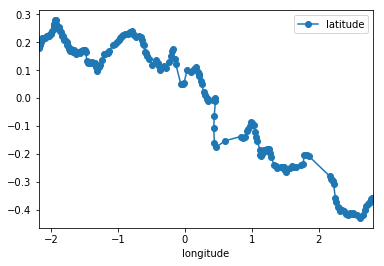

In [70]:
pd.concat([(adj_lat * 1000),(adj_lon * 1000)],axis=1).plot(x='longitude',y='latitude',marker='o')